# Initial Test of Facial Keypoint Detector
## Without PCA and an SVM for each class

First we need to identify the keypoint detector model that we will be using. 

MTCNN - Tensorflow
https://github.com/ipazc/mtcnn
(Appears to be pretrained)
It appears to provide a few facial keypoints. May be useful for patch based approach probably not for direct-point position approach.

Pytorch-Facial-Keypoints - Pytorch
https://github.com/fiyero/pytorch_facial_keypoints
(Not pretrained)
Generates keypoints around face but excludes ears. Can be used for direct-point position approach.

Openface - in Lua?
https://github.com/cmusatyalab/openface
(Might be pretrained)
Not sure if it generates keypoints

Openface - 
https://github.com/TadasBaltrusaitis/OpenFace
(Pretrained models)
High number of facial points. Can be used for direct-point position approach.

Facial-Landmark
https://github.com/huohuotm/Facial-Landmark
(pretrained models)
High number of facial points. Can be used for direct-point position approach.

Face-Recognition
https://github.com/ageitgey/face_recognition
(Is pretrained and comes as a library)
Detects facial points.

## Preprocessing images
TODO ?

## Processing on keypoints
TODO ?

## For the classifier
https://scikit-learn.org/stable/modules/svm.html
Recommend Linear SVC first

# The Plan
I am planning on using Face-Recognition which provides a wrapper around dlib face-keypoint-detector. (If we wanted to we could write our own).

Program will read in image, run face-recog for key-points, and store key-points in a CSV file.

Then using the key-points

# Second approach is an end-to-end solution

Something akin to https://github.com/ZER-0-NE/ML_problems

In [1]:
import face_recognition
image = face_recognition.load_image_file("./data/raw/Test/22q11/image_10008_jpg.jpg")
face_landmarks_list = face_recognition.face_landmarks(image)

print(image.shape)
print(face_landmarks_list)

(600, 800, 3)
[{'chin': [(340, 262), (322, 300), (308, 341), (298, 384), (295, 427), (301, 470), (314, 507), (330, 541), (357, 564), (394, 575), (433, 567), (470, 553), (502, 532), (529, 505), (552, 476), (575, 445), (596, 411)], 'left_eyebrow': [(372, 250), (395, 243), (420, 254), (440, 272), (455, 294)], 'right_eyebrow': [(497, 323), (526, 329), (552, 340), (572, 360), (578, 386)], 'nose_bridge': [(459, 338), (445, 365), (431, 391), (417, 420)], 'nose_tip': [(383, 417), (393, 429), (406, 442), (424, 445), (442, 446)], 'left_eye': [(384, 286), (401, 284), (419, 295), (424, 319), (407, 314), (391, 303)], 'right_eye': [(492, 364), (512, 359), (530, 370), (539, 390), (522, 390), (504, 380)], 'top_lip': [(347, 452), (368, 456), (387, 464), (398, 474), (414, 477), (433, 489), (450, 500), (441, 498), (408, 487), (393, 482), (382, 475), (354, 458)], 'bottom_lip': [(450, 500), (423, 508), (398, 506), (382, 500), (369, 491), (356, 475), (347, 452), (354, 458), (379, 478), (391, 486), (406, 491

In [2]:
from PIL import Image, ImageDraw
import face_recognition

# Load the jpg file into a numpy array
image = face_recognition.load_image_file("./data/raw/Test/Angelman/image_161_jpg.jpg")

# Find all facial features in all the faces in the image
face_landmarks_list = face_recognition.face_landmarks(image)

pil_image = Image.fromarray(image)
for face_landmarks in face_landmarks_list:
    d = ImageDraw.Draw(pil_image, 'RGBA')

    # Make the eyebrows into a nightmare
    d.polygon(face_landmarks['left_eyebrow'], fill=(68, 54, 39, 128))
    d.polygon(face_landmarks['right_eyebrow'], fill=(68, 54, 39, 128))
    d.line(face_landmarks['left_eyebrow'], fill=(68, 54, 39, 150), width=5)
    d.line(face_landmarks['right_eyebrow'], fill=(68, 54, 39, 150), width=5)

    # Gloss the lips
    d.polygon(face_landmarks['top_lip'], fill=(150, 0, 0, 128))
    d.polygon(face_landmarks['bottom_lip'], fill=(150, 0, 0, 128))
    d.line(face_landmarks['top_lip'], fill=(150, 0, 0, 64), width=8)
    d.line(face_landmarks['bottom_lip'], fill=(150, 0, 0, 64), width=8)

    # Sparkle the eyes
    d.polygon(face_landmarks['left_eye'], fill=(255, 255, 255, 30))
    d.polygon(face_landmarks['right_eye'], fill=(255, 255, 255, 30))

    # Apply some eyeliner
    d.line(face_landmarks['left_eye'] + [face_landmarks['left_eye'][0]], fill=(0, 0, 0, 110), width=6)
    d.line(face_landmarks['right_eye'] + [face_landmarks['right_eye'][0]], fill=(0, 0, 0, 110), width=6)

    pil_image.show()

In [3]:
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification
X, y = make_classification(n_features=4, random_state=0)
clf = LinearSVC(random_state=0, tol=1e-5)
clf.fit(X, y)
print(clf.coef_)
print(clf.intercept_)
print(clf.predict([[0, 0, 0, 0]]))

[[0.08551853 0.39414771 0.49848086 0.37514369]]
[0.28417571]
[1]


# Load image and generate landmarks

In [4]:
import os
import numpy as np
import face_recognition

LABELS = ['22q11','Angelman','Apert','CDL','Down','FragileX','Marfan','Progeria','Sotos','TreacherCollins','Turner','Williams']


def load_dataset(setPath):
    X = []
    y = []

    for label in LABELS:
        directory = os.path.join(setPath,label)
        for f in os.listdir(directory):
            path = os.path.join(directory,f)
            
            if os.path.isfile(path) and f != 'desktop.ini':
                
                # Extract landmarks
                image = face_recognition.load_image_file(path)
                face_landmarks_list = face_recognition.face_landmarks(image)

                # Iterate through detected faces
                keypoints = []
                for face in face_landmarks_list:

                    # Get face center
                    # and convert points into list form
                    cX = 0
                    cY = 0
                    count = 0
                    points = []

                    for featureType in face.keys():
                        for point in face[featureType]:
                            points = points + list(point)

                            cY = cY + point[0]
                            cX = cX + point[1]
                            count = count + 1
                    cX = cX / count
                    cY = cY / count

                    # Center all points
                    for i in range(0,len(points)):
                        if i % 2 == 0:
                            points[i] = points[i] - cY
                        else:
                            points[i] = points[i] - cX

                    # Store result
                    keypoints.append(points)

                # Append to dataset
                for facePoints in keypoints:
                    X.append(facePoints)
                    y.append(label)
    
    return np.array(X), np.array(y)

In [5]:
X_test, y_test = load_dataset('./data/raw/Test')
print(X_test.shape)
print(y_test.shape)

(312, 144)
(312,)


In [6]:
X_train, y_train = load_dataset('./data/raw/Train')
print(X_train.shape)
print(y_train.shape)

(1023, 144)
(1023,)


SVM Approach

In [7]:
from sklearn.svm import LinearSVC

clf = LinearSVC(random_state=0, tol=1e-5, max_iter=10000)
clf.fit(X_train, y_train)
print(clf.coef_)
print(clf.intercept_)

[[ 0.10019801  0.02033238 -0.01293501 ...  0.10311704  0.00382582
  -0.02161245]
 [ 0.04627985 -0.2164234  -0.06763444 ... -0.27987202  0.17123591
   0.09595782]
 [-0.11685209  0.16818827 -0.19210823 ... -0.18054411  0.03257562
  -0.21174519]
 ...
 [ 0.15712787 -0.12318642 -0.12833338 ... -0.25078485 -0.09366315
   0.11903913]
 [ 0.01596341  0.19515915  0.06042189 ... -0.18533853  0.06344362
  -0.02838656]
 [-0.02840746 -0.19262492  0.00243679 ...  0.01597841 -0.16346589
  -0.08416011]]
[-0.27810576 -1.24598348 -0.49805885 -0.92951409 -1.10971039  0.15390712
 -0.36607845 -0.44500052 -0.08861473 -0.75795422  0.08240735 -0.3952285 ]


/home/curt/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


y_pred = clf.predict(X_train)

accuracy = accuracy_score(y_train, y_pred, normalize=False) / float(y_train.size)
print('accuracy',accuracy)

conf = confusion_matrix(y_train,y_pred)

accuracy 0.7565982404692082


Text(69.0, 0.5, 'Actual')

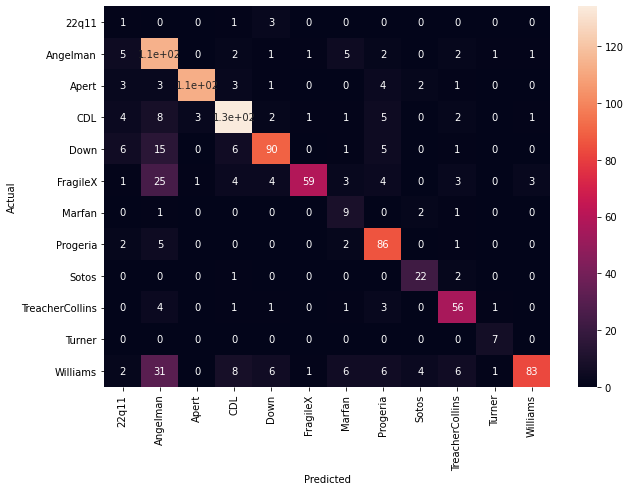

In [9]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(conf, index = [i for i in LABELS],
                  columns = [i for i in LABELS])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred, normalize=False) / float(y_test.size)
print('accuracy',accuracy)

conf = confusion_matrix(y_test,y_pred)

accuracy 0.5288461538461539


Text(69.0, 0.5, 'Actual')

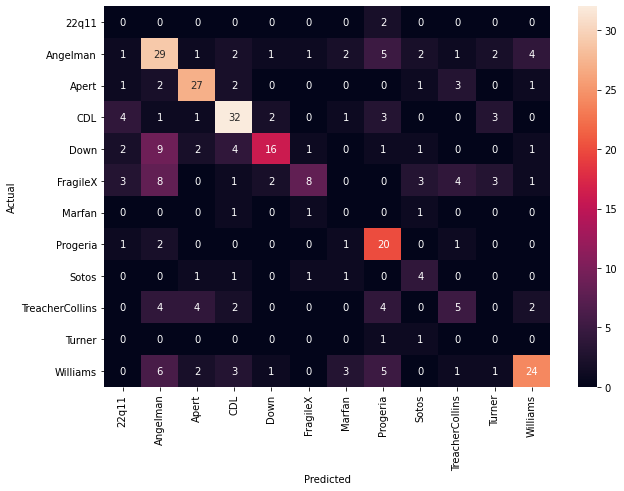

In [11]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(conf, index = [i for i in LABELS],
                  columns = [i for i in LABELS])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')

Neural Network Approach

In [12]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='adam', alpha=1e-4, hidden_layer_sizes=(100, 50), max_iter=2000, verbose=True, n_iter_no_change=500)
clf.fit(X_train, y_train)

Iteration 1, loss = 27.75291566
Iteration 2, loss = 9.44634045
Iteration 3, loss = 6.08551741
Iteration 4, loss = 5.07614409
Iteration 5, loss = 3.84024131
Iteration 6, loss = 3.44165438
Iteration 7, loss = 3.21729207
Iteration 8, loss = 2.95569748
Iteration 9, loss = 2.88640695
Iteration 10, loss = 2.71236101
Iteration 11, loss = 2.47156062
Iteration 12, loss = 2.38979596
Iteration 13, loss = 2.28708574
Iteration 14, loss = 2.23525087
Iteration 15, loss = 2.41632327
Iteration 16, loss = 2.29134432
Iteration 17, loss = 2.26502944
Iteration 18, loss = 2.18021271
Iteration 19, loss = 2.18014640
Iteration 20, loss = 2.11522528
Iteration 21, loss = 2.09295042
Iteration 22, loss = 2.05630022
Iteration 23, loss = 2.05044951
Iteration 24, loss = 2.13375002
Iteration 25, loss = 2.06128675
Iteration 26, loss = 1.93569953
Iteration 27, loss = 2.01234266
Iteration 28, loss = 1.94079490
Iteration 29, loss = 1.92196733
Iteration 30, loss = 2.07990725
Iteration 31, loss = 1.88013574
Iteration 32, lo

Iteration 258, loss = 1.11701223
Iteration 259, loss = 1.20805053
Iteration 260, loss = 1.14887473
Iteration 261, loss = 1.14346061
Iteration 262, loss = 1.12435387
Iteration 263, loss = 1.12467442
Iteration 264, loss = 1.16757875
Iteration 265, loss = 1.13106467
Iteration 266, loss = 1.11801585
Iteration 267, loss = 1.20085302
Iteration 268, loss = 1.16110709
Iteration 269, loss = 1.14174718
Iteration 270, loss = 1.13203189
Iteration 271, loss = 1.12631210
Iteration 272, loss = 1.09666661
Iteration 273, loss = 1.15412229
Iteration 274, loss = 1.14978769
Iteration 275, loss = 1.14518689
Iteration 276, loss = 1.18105378
Iteration 277, loss = 1.13602195
Iteration 278, loss = 1.20210034
Iteration 279, loss = 1.13916667
Iteration 280, loss = 1.14779505
Iteration 281, loss = 1.16409745
Iteration 282, loss = 1.09961562
Iteration 283, loss = 1.11867790
Iteration 284, loss = 1.17104963
Iteration 285, loss = 1.14611196
Iteration 286, loss = 1.13528882
Iteration 287, loss = 1.12982763
Iteration 

Iteration 509, loss = 0.88542156
Iteration 510, loss = 0.90019294
Iteration 511, loss = 0.90286440
Iteration 512, loss = 0.83687556
Iteration 513, loss = 0.82092407
Iteration 514, loss = 0.82656601
Iteration 515, loss = 0.90296854
Iteration 516, loss = 0.89107066
Iteration 517, loss = 0.85951828
Iteration 518, loss = 0.83869216
Iteration 519, loss = 0.90220065
Iteration 520, loss = 0.84132408
Iteration 521, loss = 0.89525500
Iteration 522, loss = 0.86795261
Iteration 523, loss = 0.88861199
Iteration 524, loss = 0.90732567
Iteration 525, loss = 0.89700006
Iteration 526, loss = 0.93652684
Iteration 527, loss = 0.89060606
Iteration 528, loss = 0.83497907
Iteration 529, loss = 0.83118042
Iteration 530, loss = 0.84161652
Iteration 531, loss = 0.83352360
Iteration 532, loss = 0.79531606
Iteration 533, loss = 0.80968698
Iteration 534, loss = 0.78942425
Iteration 535, loss = 0.80974373
Iteration 536, loss = 0.81404358
Iteration 537, loss = 0.85639102
Iteration 538, loss = 0.82648031
Iteration 

Iteration 758, loss = 0.60277315
Iteration 759, loss = 0.58436489
Iteration 760, loss = 0.59634787
Iteration 761, loss = 0.58149265
Iteration 762, loss = 0.58468098
Iteration 763, loss = 0.68573629
Iteration 764, loss = 0.74087662
Iteration 765, loss = 0.60219282
Iteration 766, loss = 0.57362525
Iteration 767, loss = 0.58767231
Iteration 768, loss = 0.55892659
Iteration 769, loss = 0.60454596
Iteration 770, loss = 0.57386060
Iteration 771, loss = 0.55491161
Iteration 772, loss = 0.58926561
Iteration 773, loss = 0.59819011
Iteration 774, loss = 0.60386431
Iteration 775, loss = 0.57507905
Iteration 776, loss = 0.58118035
Iteration 777, loss = 0.54755778
Iteration 778, loss = 0.56721256
Iteration 779, loss = 0.57134270
Iteration 780, loss = 0.61300721
Iteration 781, loss = 0.62170664
Iteration 782, loss = 0.72407397
Iteration 783, loss = 0.60264936
Iteration 784, loss = 0.58144697
Iteration 785, loss = 0.65871672
Iteration 786, loss = 0.58254761
Iteration 787, loss = 0.62110940
Iteration 

Iteration 1009, loss = 0.48230431
Iteration 1010, loss = 0.43241803
Iteration 1011, loss = 0.45356810
Iteration 1012, loss = 0.46289467
Iteration 1013, loss = 0.45026498
Iteration 1014, loss = 0.45316359
Iteration 1015, loss = 0.45709793
Iteration 1016, loss = 0.42958724
Iteration 1017, loss = 0.41450716
Iteration 1018, loss = 0.43481601
Iteration 1019, loss = 0.42281514
Iteration 1020, loss = 0.41356967
Iteration 1021, loss = 0.40836261
Iteration 1022, loss = 0.38945390
Iteration 1023, loss = 0.45212172
Iteration 1024, loss = 0.42159245
Iteration 1025, loss = 0.41338996
Iteration 1026, loss = 0.39209203
Iteration 1027, loss = 0.41373043
Iteration 1028, loss = 0.40832555
Iteration 1029, loss = 0.43110532
Iteration 1030, loss = 0.42673243
Iteration 1031, loss = 0.40795697
Iteration 1032, loss = 0.40424195
Iteration 1033, loss = 0.41415056
Iteration 1034, loss = 0.38019805
Iteration 1035, loss = 0.37871002
Iteration 1036, loss = 0.41342929
Iteration 1037, loss = 0.41007962
Iteration 1038

Iteration 1250, loss = 0.34326404
Iteration 1251, loss = 0.31739602
Iteration 1252, loss = 0.29049211
Iteration 1253, loss = 0.28958762
Iteration 1254, loss = 0.29794837
Iteration 1255, loss = 0.28660388
Iteration 1256, loss = 0.30149981
Iteration 1257, loss = 0.29927136
Iteration 1258, loss = 0.29798420
Iteration 1259, loss = 0.31452188
Iteration 1260, loss = 0.29709891
Iteration 1261, loss = 0.27531936
Iteration 1262, loss = 0.27705201
Iteration 1263, loss = 0.28821006
Iteration 1264, loss = 0.32422841
Iteration 1265, loss = 0.33250649
Iteration 1266, loss = 0.35384808
Iteration 1267, loss = 0.31577072
Iteration 1268, loss = 0.31518093
Iteration 1269, loss = 0.37852854
Iteration 1270, loss = 0.29105924
Iteration 1271, loss = 0.35981880
Iteration 1272, loss = 0.33880900
Iteration 1273, loss = 0.31886287
Iteration 1274, loss = 0.31943931
Iteration 1275, loss = 0.38634935
Iteration 1276, loss = 0.50070523
Iteration 1277, loss = 0.47405290
Iteration 1278, loss = 0.43931603
Iteration 1279

Iteration 1491, loss = 0.28291790
Iteration 1492, loss = 0.35496180
Iteration 1493, loss = 0.27890924
Iteration 1494, loss = 0.29751670
Iteration 1495, loss = 0.26742409
Iteration 1496, loss = 0.25690004
Iteration 1497, loss = 0.29146638
Iteration 1498, loss = 0.24813648
Iteration 1499, loss = 0.26334184
Iteration 1500, loss = 0.23980804
Iteration 1501, loss = 0.25142727
Iteration 1502, loss = 0.24845910
Iteration 1503, loss = 0.28437367
Iteration 1504, loss = 0.26914354
Iteration 1505, loss = 0.26183105
Iteration 1506, loss = 0.24319700
Iteration 1507, loss = 0.28438835
Iteration 1508, loss = 0.26955406
Iteration 1509, loss = 0.27426061
Iteration 1510, loss = 0.27626205
Iteration 1511, loss = 0.34139208
Iteration 1512, loss = 0.33814257
Iteration 1513, loss = 0.29775463
Iteration 1514, loss = 0.35159768
Iteration 1515, loss = 0.44160115
Iteration 1516, loss = 0.41398244
Iteration 1517, loss = 0.38804315
Iteration 1518, loss = 0.30401727
Iteration 1519, loss = 0.28030422
Iteration 1520

Iteration 1738, loss = 0.24647472
Iteration 1739, loss = 0.23306159
Iteration 1740, loss = 0.23957762
Iteration 1741, loss = 0.23572393
Iteration 1742, loss = 0.24008666
Iteration 1743, loss = 0.21273753
Iteration 1744, loss = 0.23581154
Iteration 1745, loss = 0.23139769
Iteration 1746, loss = 0.23760580
Iteration 1747, loss = 0.25211172
Iteration 1748, loss = 0.22096036
Iteration 1749, loss = 0.21968796
Iteration 1750, loss = 0.21078664
Iteration 1751, loss = 0.23172152
Iteration 1752, loss = 0.20405456
Iteration 1753, loss = 0.20572199
Iteration 1754, loss = 0.20562641
Iteration 1755, loss = 0.20018464
Iteration 1756, loss = 0.20059475
Iteration 1757, loss = 0.21787124
Iteration 1758, loss = 0.21894168
Iteration 1759, loss = 0.25314196
Iteration 1760, loss = 0.26223875
Iteration 1761, loss = 0.27223158
Iteration 1762, loss = 0.37376499
Iteration 1763, loss = 0.33629459
Iteration 1764, loss = 0.27344271
Iteration 1765, loss = 0.26389065
Iteration 1766, loss = 0.20755149
Iteration 1767

Iteration 1979, loss = 0.15824252
Iteration 1980, loss = 0.13535864
Iteration 1981, loss = 0.13774985
Iteration 1982, loss = 0.14427611
Iteration 1983, loss = 0.13815822
Iteration 1984, loss = 0.12969818
Iteration 1985, loss = 0.13323867
Iteration 1986, loss = 0.13603789
Iteration 1987, loss = 0.13809671
Iteration 1988, loss = 0.13899226
Iteration 1989, loss = 0.13298863
Iteration 1990, loss = 0.13565441
Iteration 1991, loss = 0.13873925
Iteration 1992, loss = 0.14124133
Iteration 1993, loss = 0.17750292
Iteration 1994, loss = 0.16468264
Iteration 1995, loss = 0.21561027
Iteration 1996, loss = 0.20892770
Iteration 1997, loss = 0.22692255
Iteration 1998, loss = 0.21216803
Iteration 1999, loss = 0.25810786
Iteration 2000, loss = 0.21769849


/home/curt/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 50), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=2000,
              momentum=0.9, n_iter_no_change=500, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=True,
              warm_start=False)

In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


y_pred = clf.predict(X_train)

accuracy = accuracy_score(y_train, y_pred, normalize=False) / float(y_train.size)
print('accuracy',accuracy)

conf = confusion_matrix(y_train,y_pred)

accuracy 0.9393939393939394


Text(69.0, 0.5, 'Actual')

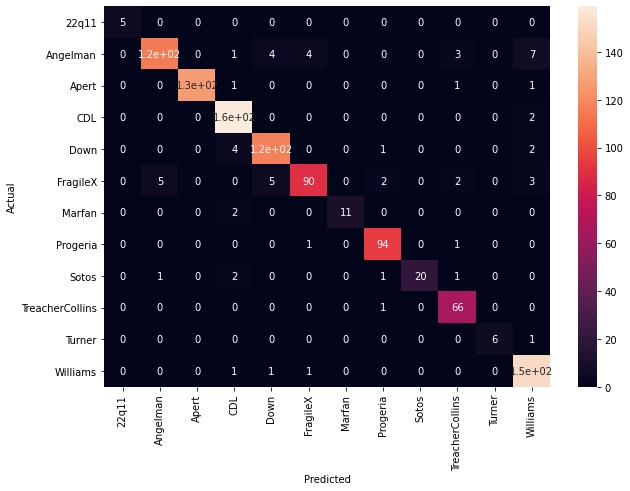

In [14]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(conf, index = [i for i in LABELS],
                  columns = [i for i in LABELS])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred, normalize=False) / float(y_test.size)
print('accuracy',accuracy)

conf = confusion_matrix(y_test,y_pred)

accuracy 0.5352564102564102


Text(69.0, 0.5, 'Actual')

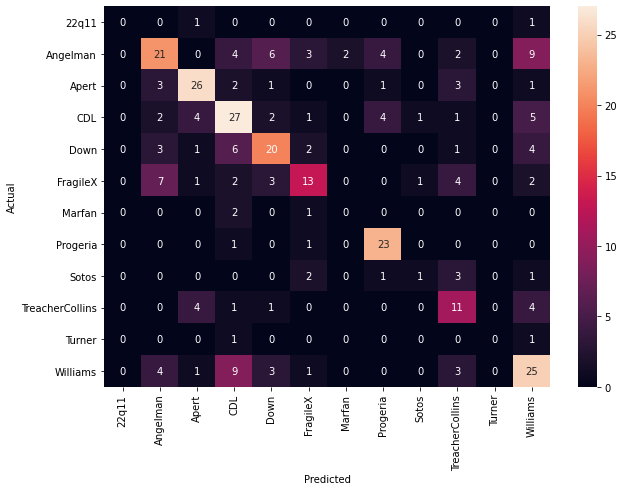

In [16]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(conf, index = [i for i in LABELS],
                  columns = [i for i in LABELS])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')

PCA SVM

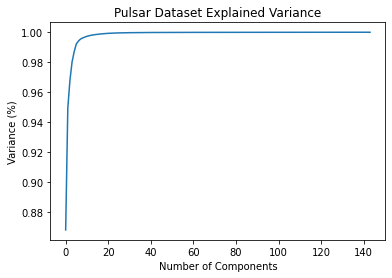

In [17]:
import numpy as np
from sklearn.decomposition import PCA 

pca = PCA().fit(X_train)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=15)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [19]:
from sklearn.svm import LinearSVC

clf = LinearSVC(random_state=0, tol=1e-5, max_iter=10000)
clf.fit(X_train_pca, y_train)
print(clf.coef_)
print(clf.intercept_)

[[ 6.56265611e-05 -5.13600441e-04  3.20085732e-04 -2.35038453e-04
   7.55375959e-04 -1.00105446e-04  8.60333227e-04 -1.85557251e-04
  -4.91925152e-04  2.69157493e-04 -2.57203616e-04 -5.49876788e-04
   8.68446671e-05  3.59048009e-04  2.76840109e-04]
 [-4.43455616e-04  1.94122535e-03  8.29615034e-04  2.59577247e-03
   1.45813892e-02 -2.00572560e-02 -6.77283905e-03  2.45168328e-02
   7.35715543e-03 -1.47519042e-02  2.86266640e-03 -1.18627055e-03
  -9.90077735e-03  5.47754081e-02 -8.09398230e-03]
 [-2.02073419e-03  1.23541063e-03 -1.40419568e-04 -1.53584395e-02
  -1.56337023e-02  8.91726214e-03 -2.87011421e-02  6.72908976e-03
   5.29709864e-02 -4.55637199e-02  5.09657984e-02  7.59420973e-03
  -1.84661426e-03  2.50082511e-02 -7.38113547e-03]
 [ 1.89399597e-03 -3.54292130e-03  2.00720698e-03 -1.17026035e-02
  -9.98367443e-03  5.64175287e-03  1.41273254e-02 -6.39029533e-03
   9.28288079e-03  2.85536664e-02 -2.19479591e-02  3.78885143e-02
   1.20145783e-02 -3.06348530e-02 -1.74278463e-02]
 [ 1

/home/curt/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


y_pred = clf.predict(X_train_pca)

accuracy = accuracy_score(y_train, y_pred, normalize=False) / float(y_train.size)
print('accuracy',accuracy)

conf = confusion_matrix(y_train,y_pred)

accuracy 0.35777126099706746


Text(69.0, 0.5, 'Actual')

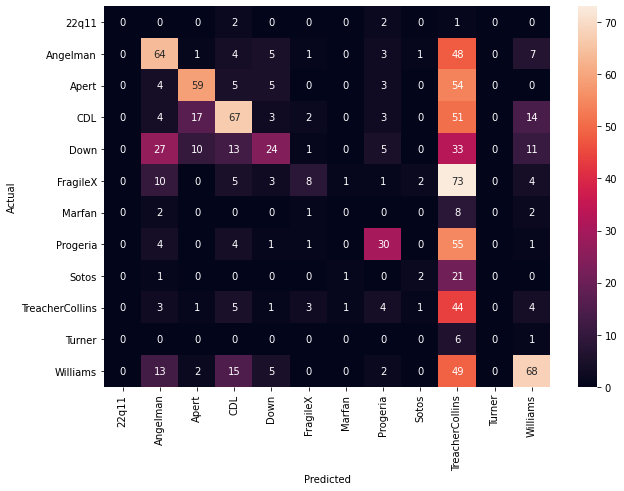

In [21]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(conf, index = [i for i in LABELS],
                  columns = [i for i in LABELS])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


y_pred = clf.predict(X_test_pca)

accuracy = accuracy_score(y_test, y_pred, normalize=False) / float(y_test.size)
print('accuracy',accuracy)

conf = confusion_matrix(y_test,y_pred)

accuracy 0.28846153846153844


Text(69.0, 0.5, 'Actual')

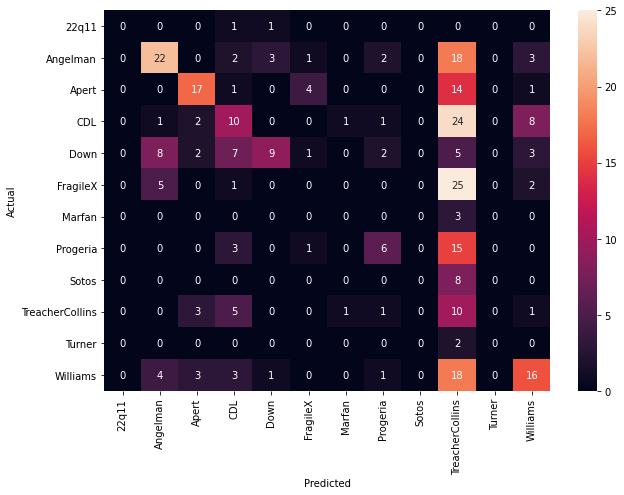

In [23]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(conf, index = [i for i in LABELS],
                  columns = [i for i in LABELS])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')

PCA Neural Network

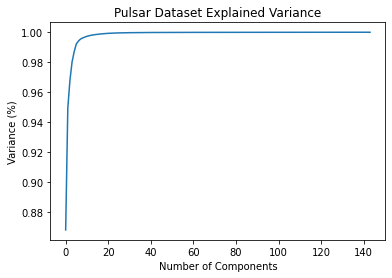

In [24]:
import numpy as np
from sklearn.decomposition import PCA 

pca = PCA().fit(X_train)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

In [25]:
from sklearn.decomposition import PCA
pca = PCA(n_components=15)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [26]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='adam', alpha=1e-4, hidden_layer_sizes=(100, 50), max_iter=2000, verbose=True, n_iter_no_change=500)
clf.fit(X_train_pca, y_train)

Iteration 1, loss = 32.10237787
Iteration 2, loss = 16.68948226
Iteration 3, loss = 12.07836583
Iteration 4, loss = 8.77310804
Iteration 5, loss = 7.32750057
Iteration 6, loss = 5.91760831
Iteration 7, loss = 4.85996475
Iteration 8, loss = 4.06770453
Iteration 9, loss = 3.46694987
Iteration 10, loss = 3.09140534
Iteration 11, loss = 2.76088403
Iteration 12, loss = 2.52388301
Iteration 13, loss = 2.37179604
Iteration 14, loss = 2.23366649
Iteration 15, loss = 2.13861943
Iteration 16, loss = 2.04106851
Iteration 17, loss = 2.06059742
Iteration 18, loss = 1.93454280
Iteration 19, loss = 1.86809567
Iteration 20, loss = 1.78556295
Iteration 21, loss = 1.70738627
Iteration 22, loss = 1.71918473
Iteration 23, loss = 1.67244015
Iteration 24, loss = 1.63601045
Iteration 25, loss = 1.57959317
Iteration 26, loss = 1.59735633
Iteration 27, loss = 1.53528094
Iteration 28, loss = 1.51571456
Iteration 29, loss = 1.46155720
Iteration 30, loss = 1.46607475
Iteration 31, loss = 1.40756168
Iteration 32, 

Iteration 263, loss = 0.49008459
Iteration 264, loss = 0.48965904
Iteration 265, loss = 0.49242075
Iteration 266, loss = 0.51771595
Iteration 267, loss = 0.48270867
Iteration 268, loss = 0.49234364
Iteration 269, loss = 0.48649103
Iteration 270, loss = 0.52463231
Iteration 271, loss = 0.51084477
Iteration 272, loss = 0.49109372
Iteration 273, loss = 0.49965274
Iteration 274, loss = 0.52060433
Iteration 275, loss = 0.47529746
Iteration 276, loss = 0.46672904
Iteration 277, loss = 0.50146423
Iteration 278, loss = 0.49008577
Iteration 279, loss = 0.47676201
Iteration 280, loss = 0.48044514
Iteration 281, loss = 0.48271385
Iteration 282, loss = 0.47624826
Iteration 283, loss = 0.50594406
Iteration 284, loss = 0.50613745
Iteration 285, loss = 0.50656847
Iteration 286, loss = 0.47971426
Iteration 287, loss = 0.44599109
Iteration 288, loss = 0.48037540
Iteration 289, loss = 0.48434800
Iteration 290, loss = 0.46235540
Iteration 291, loss = 0.47464750
Iteration 292, loss = 0.45963796
Iteration 

Iteration 513, loss = 0.25631189
Iteration 514, loss = 0.26383639
Iteration 515, loss = 0.26977460
Iteration 516, loss = 0.28420621
Iteration 517, loss = 0.28042674
Iteration 518, loss = 0.26687370
Iteration 519, loss = 0.29434215
Iteration 520, loss = 0.26336682
Iteration 521, loss = 0.28200356
Iteration 522, loss = 0.26900733
Iteration 523, loss = 0.27227312
Iteration 524, loss = 0.26391275
Iteration 525, loss = 0.24854321
Iteration 526, loss = 0.24357325
Iteration 527, loss = 0.25974839
Iteration 528, loss = 0.28393408
Iteration 529, loss = 0.27080970
Iteration 530, loss = 0.27282447
Iteration 531, loss = 0.27146970
Iteration 532, loss = 0.25786075
Iteration 533, loss = 0.25324190
Iteration 534, loss = 0.26407156
Iteration 535, loss = 0.27029740
Iteration 536, loss = 0.29713852
Iteration 537, loss = 0.25017638
Iteration 538, loss = 0.25892251
Iteration 539, loss = 0.25448284
Iteration 540, loss = 0.26985485
Iteration 541, loss = 0.24421539
Iteration 542, loss = 0.24638208
Iteration 

Iteration 771, loss = 0.21030034
Iteration 772, loss = 0.16547979
Iteration 773, loss = 0.19438170
Iteration 774, loss = 0.19875153
Iteration 775, loss = 0.17598643
Iteration 776, loss = 0.15922350
Iteration 777, loss = 0.16765606
Iteration 778, loss = 0.15465624
Iteration 779, loss = 0.14289362
Iteration 780, loss = 0.14085201
Iteration 781, loss = 0.14819007
Iteration 782, loss = 0.16945929
Iteration 783, loss = 0.17511877
Iteration 784, loss = 0.17639898
Iteration 785, loss = 0.17617227
Iteration 786, loss = 0.15316987
Iteration 787, loss = 0.13519922
Iteration 788, loss = 0.12998149
Iteration 789, loss = 0.12615564
Iteration 790, loss = 0.12412030
Iteration 791, loss = 0.12297767
Iteration 792, loss = 0.12899323
Iteration 793, loss = 0.16718569
Iteration 794, loss = 0.22053490
Iteration 795, loss = 0.17049504
Iteration 796, loss = 0.15212864
Iteration 797, loss = 0.14765813
Iteration 798, loss = 0.13993800
Iteration 799, loss = 0.15119634
Iteration 800, loss = 0.16097874
Iteration 

Iteration 1026, loss = 0.06503376
Iteration 1027, loss = 0.08191646
Iteration 1028, loss = 0.07356732
Iteration 1029, loss = 0.10034096
Iteration 1030, loss = 0.29152200
Iteration 1031, loss = 0.32860347
Iteration 1032, loss = 0.49397672
Iteration 1033, loss = 0.72243023
Iteration 1034, loss = 0.94906167
Iteration 1035, loss = 0.54610685
Iteration 1036, loss = 0.56741406
Iteration 1037, loss = 0.39168001
Iteration 1038, loss = 0.33805856
Iteration 1039, loss = 0.47296125
Iteration 1040, loss = 0.54414879
Iteration 1041, loss = 0.31123973
Iteration 1042, loss = 0.27592920
Iteration 1043, loss = 0.29201934
Iteration 1044, loss = 0.21107605
Iteration 1045, loss = 0.15213640
Iteration 1046, loss = 0.16142371
Iteration 1047, loss = 0.15756209
Iteration 1048, loss = 0.21022481
Iteration 1049, loss = 0.20432478
Iteration 1050, loss = 0.15128204
Iteration 1051, loss = 0.11778735
Iteration 1052, loss = 0.10228095
Iteration 1053, loss = 0.12752653
Iteration 1054, loss = 0.10074377
Iteration 1055

Iteration 1271, loss = 0.03120335
Iteration 1272, loss = 0.02931919
Iteration 1273, loss = 0.03418000
Iteration 1274, loss = 0.02481467
Iteration 1275, loss = 0.02582589
Iteration 1276, loss = 0.02529364
Iteration 1277, loss = 0.02696586
Iteration 1278, loss = 0.02419690
Iteration 1279, loss = 0.02781051
Iteration 1280, loss = 0.02673101
Iteration 1281, loss = 0.04151436
Iteration 1282, loss = 0.03491772
Iteration 1283, loss = 0.05024286
Iteration 1284, loss = 0.04307923
Iteration 1285, loss = 0.04120535
Iteration 1286, loss = 0.04054199
Iteration 1287, loss = 0.04635742
Iteration 1288, loss = 0.05553987
Iteration 1289, loss = 0.04724930
Iteration 1290, loss = 0.05260013
Iteration 1291, loss = 0.05034903
Iteration 1292, loss = 0.04069806
Iteration 1293, loss = 0.05085721
Iteration 1294, loss = 0.06065652
Iteration 1295, loss = 0.06125861
Iteration 1296, loss = 0.05971987
Iteration 1297, loss = 0.08890966
Iteration 1298, loss = 0.13753111
Iteration 1299, loss = 0.09653672
Iteration 1300

Iteration 1522, loss = 0.01640296
Iteration 1523, loss = 0.01746468
Iteration 1524, loss = 0.01691004
Iteration 1525, loss = 0.01853248
Iteration 1526, loss = 0.01677982
Iteration 1527, loss = 0.01795643
Iteration 1528, loss = 0.01470153
Iteration 1529, loss = 0.01554913
Iteration 1530, loss = 0.01568111
Iteration 1531, loss = 0.02968994
Iteration 1532, loss = 0.02816962
Iteration 1533, loss = 0.01916252
Iteration 1534, loss = 0.02281893
Iteration 1535, loss = 0.01664814
Iteration 1536, loss = 0.01818271
Iteration 1537, loss = 0.01708351
Iteration 1538, loss = 0.01547531
Iteration 1539, loss = 0.01349237
Iteration 1540, loss = 0.01371177
Iteration 1541, loss = 0.01235906
Iteration 1542, loss = 0.01166632
Iteration 1543, loss = 0.01146909
Iteration 1544, loss = 0.01157382
Iteration 1545, loss = 0.01097412
Iteration 1546, loss = 0.01053410
Iteration 1547, loss = 0.01099678
Iteration 1548, loss = 0.01081393
Iteration 1549, loss = 0.01052332
Iteration 1550, loss = 0.01165595
Iteration 1551

Iteration 1771, loss = 0.06869138
Iteration 1772, loss = 0.04585863
Iteration 1773, loss = 0.03642810
Iteration 1774, loss = 0.09604085
Iteration 1775, loss = 0.09735076
Iteration 1776, loss = 0.11312673
Iteration 1777, loss = 0.13749212
Iteration 1778, loss = 0.12187409
Iteration 1779, loss = 0.08968170
Iteration 1780, loss = 0.04468481
Iteration 1781, loss = 0.04370979
Iteration 1782, loss = 0.03323077
Iteration 1783, loss = 0.07299668
Iteration 1784, loss = 0.06448018
Iteration 1785, loss = 0.03585961
Iteration 1786, loss = 0.03061329
Iteration 1787, loss = 0.03071897
Iteration 1788, loss = 0.02335306
Iteration 1789, loss = 0.02417813
Iteration 1790, loss = 0.02778105
Iteration 1791, loss = 0.01205931
Iteration 1792, loss = 0.01638769
Iteration 1793, loss = 0.01821485
Iteration 1794, loss = 0.01163648
Iteration 1795, loss = 0.01052332
Iteration 1796, loss = 0.00887928
Iteration 1797, loss = 0.00796006
Iteration 1798, loss = 0.00769848
Iteration 1799, loss = 0.00713709
Iteration 1800

/home/curt/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 50), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=2000,
              momentum=0.9, n_iter_no_change=500, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=True,
              warm_start=False)

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


y_pred = clf.predict(X_train_pca)

accuracy = accuracy_score(y_train, y_pred, normalize=False) / float(y_train.size)
print('accuracy',accuracy)

conf = confusion_matrix(y_train,y_pred)

accuracy 1.0


Text(69.0, 0.5, 'Actual')

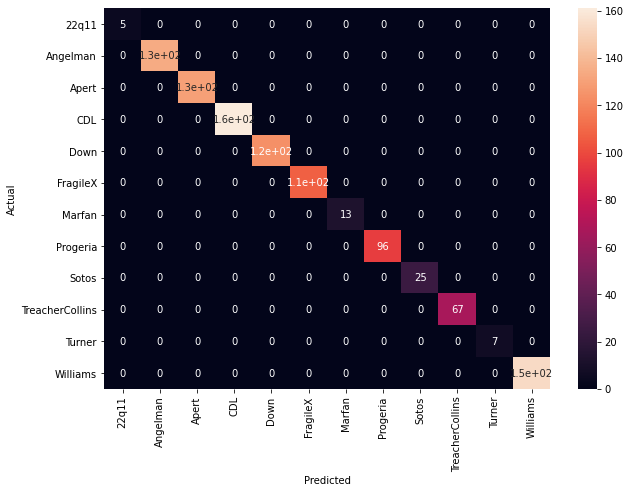

In [28]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(conf, index = [i for i in LABELS],
                  columns = [i for i in LABELS])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [29]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


y_pred = clf.predict(X_test_pca)

accuracy = accuracy_score(y_test, y_pred, normalize=False) / float(y_test.size)
print('accuracy',accuracy)

conf = confusion_matrix(y_test,y_pred)

accuracy 0.4519230769230769


Text(69.0, 0.5, 'Actual')

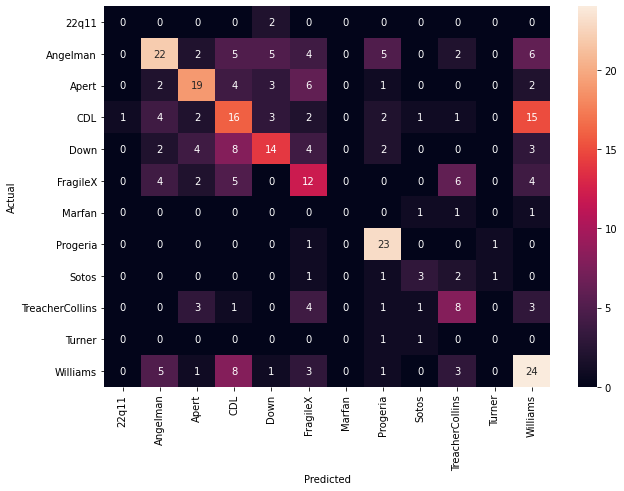

In [30]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(conf, index = [i for i in LABELS],
                  columns = [i for i in LABELS])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')